# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [18]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [19]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [20]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [21]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(in_features=num_features, out_features=n_hidden_1, name="layer1")
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2, name="layer2")
    # Вихідний шар
    self.output_layer = DenseLayer(in_features=n_hidden_2, out_features=num_classes, name="output_layer")



  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x, activation=1)
    x = self.layer2(x, activation=1)
    return self.output_layer(x, activation=1)

In [22]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [23]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

  # Отримаємо список оптимізованих параметрів
  trainable_variables = neural_net.trainable_variables

  # Обчислимо за ними значення градієнта
  gradients = g.gradient(loss, trainable_variables)

  # Модифікуємо параметри
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss

In [24]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    loss = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        acc = accuracy(pred, batch_y)

        loss_history.append(loss.numpy())
        accuracy_history.append(acc.numpy())

        print(f"Step {step}, Loss: {loss}, Accuracy: {acc}")


Step 100, Loss: 584.8419189453125, Accuracy: 0.1796875
Step 200, Loss: 583.1902465820312, Accuracy: 0.1875
Step 300, Loss: 583.5782470703125, Accuracy: 0.2109375
Step 400, Loss: 581.0181274414062, Accuracy: 0.2421875
Step 500, Loss: 577.4632568359375, Accuracy: 0.25
Step 600, Loss: 578.818603515625, Accuracy: 0.18359375
Step 700, Loss: 572.0532836914062, Accuracy: 0.21484375
Step 800, Loss: 558.6851196289062, Accuracy: 0.28515625
Step 900, Loss: 544.1773681640625, Accuracy: 0.25390625
Step 1000, Loss: 534.0545654296875, Accuracy: 0.28125
Step 1100, Loss: 506.85833740234375, Accuracy: 0.28125
Step 1200, Loss: 514.08154296875, Accuracy: 0.25
Step 1300, Loss: 509.95074462890625, Accuracy: 0.2265625
Step 1400, Loss: 486.07598876953125, Accuracy: 0.33203125
Step 1500, Loss: 461.1309814453125, Accuracy: 0.34765625
Step 1600, Loss: 464.197998046875, Accuracy: 0.35546875
Step 1700, Loss: 433.7707214355469, Accuracy: 0.37109375
Step 1800, Loss: 426.5492858886719, Accuracy: 0.33984375
Step 1900,

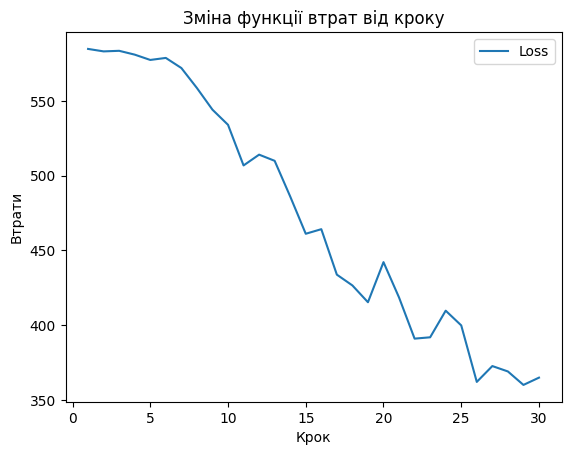

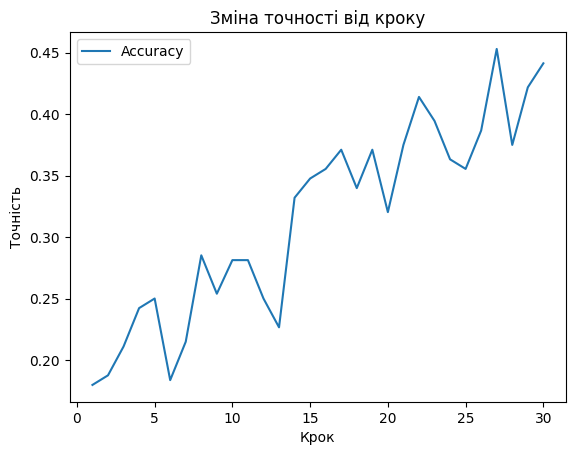

In [25]:
import matplotlib.pyplot as plt

# Графік функції втрат
plt.plot(range(1, len(loss_history) + 1), loss_history, label='Loss')
plt.title('Зміна функції втрат від кроку')
plt.xlabel('Крок')
plt.ylabel('Втрати')
plt.legend()
plt.show()

# Графік точності
plt.plot(range(1, len(accuracy_history) + 1), accuracy_history, label='Accuracy')
plt.title('Зміна точності від кроку')
plt.xlabel('Крок')
plt.ylabel('Точність')
plt.legend()
plt.show()


In [27]:
# Обчисліть точність навченої нейромережі
# Місце для вашого коду
# Тестування моделі на тестових даних
# Місце для вашого коду
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

test_accuracy = tf.keras.metrics.Accuracy()

for batch_x_test, batch_y_test in test_data:
    pred_test = neural_net(batch_x_test)
    test_accuracy.update_state(tf.argmax(pred_test, axis=1), batch_y_test)

print(f"Точність на тестових даних: {test_accuracy.result().numpy()}")


Точність на тестових даних: 0.447299987077713


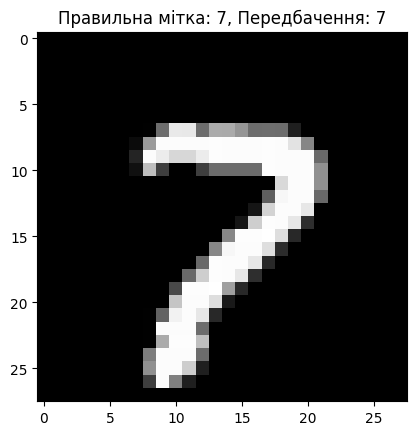

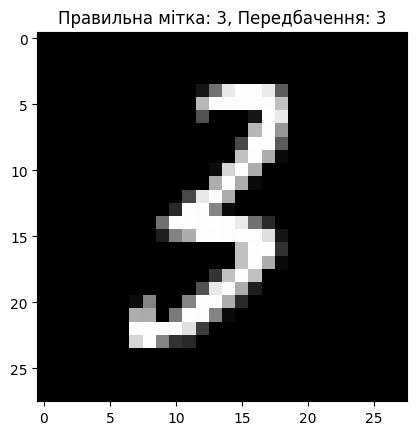

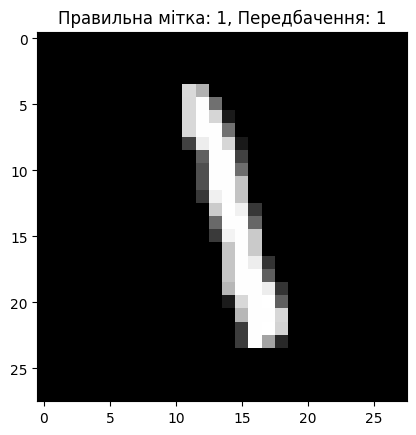

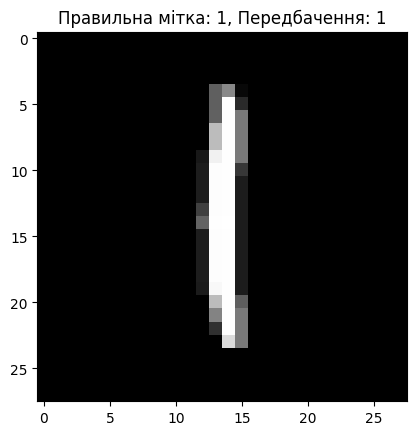

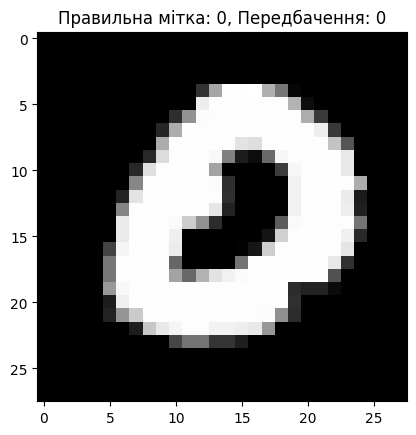

In [29]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

import numpy as np

random_indices = np.random.choice(len(x_test), size=5, replace=False)
test_images = x_test[random_indices]
test_labels = y_test[random_indices]

predictions = neural_net(test_images)


for i in range(5):
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"Правильна мітка: {test_labels[i]}, Передбачення: {tf.argmax(predictions[i])}")
    plt.show()





1. Точність на тренувальних даних є невисокою.
2. Точність на тестових даних теж є невисокою (приблизно 48%). Модель може досить часто помилятися при класифікації зображень рукописних цифр.
3. Модель помиляється не часто,  це свідчить про те, що модель виявляється досить ефективною для певних екземплярів даних, але є проблеми з загальною узагальненістю.
Нейромережа потребує подальшого налаштування та експериментів. Підвищення точності може вимагати зміни архітектури, оптимізації гіперпараметрів та, можливо, збільшення обсягу навчальних даних. Аналіз та експерименти є ключовими для поліпшення результатів нейромережі.





